# 카메라 스티커앱 만들기
- 얼굴인식 카메라앱 만들기
- 동영상 처리, 검출
- 키포인트 추청, 추적
- 카메라 원근

## 목차
1. 이미지 준비

## 1. 이미지 준비

스티커를 세밀하고 자연스럽게 적용하기 위해 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 게 중요하다.
이 위치들을 찾아내는 기술을 랜드마크 또는 조정(alignment)라고 한다.

더 큰 범위로는 keypoint detection이라고 부른다.

- 1) 얼굴 사진을 준비한다.
- 2) 사진에서 얼굴 영역 face landmark를 찾아낸다.(landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야 한다.)
- 3) 찾은 영역으로부터 머리에 왕관 스티커를 붙여 넣는다.

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

이미지 크기 변경
- 4:3, 즉 640x480로 변경

## 이미지 종횡비가 중요한건가????

추가) cv2.imread()의 flag 값 (1, 0, -1)
1. cv2.IMREAD_COLOR -> flag = 1
- cv2.imread('img.png', 1)
- 이미지 파일을 color로 읽어 들인다.
- default 값
- 투명한 부분은 무시

2. cv2.IMREAD_GRAYSCALE -> flag = 0
- cv2.imread('img.png', 0)
- 이지미를 grayscale로 읽어 들인다.
- 실제 이미지 처리시 중간 단계로 많이 사용한다.

3. cv2.IMREAD_UNCHANGED -> flag = -1
- cv2.imread('img.png', -1)
- 이미지 파일을 alpha channel까지 포함해 읽어 들인다.

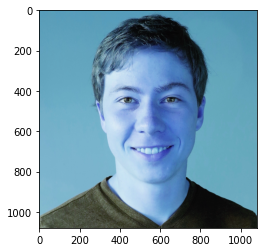

In [2]:
my_img_path = os.getenv('HOME') + '/aiffel/aiffel_projects/data/camera_sticker/images/image.png'

# OpenCV로 이미지 읽어와서 크기 변경
img_bgr = cv2.imread(my_img_path)
img_bgr = cv2.resize(img_bgr, (1080, 1080))
img_show = img_bgr.copy() # 출력용 이미지 별도 보관

plt.imshow(img_bgr)
plt.show()

그런데 사진 색깔이 좀 이상하다?
- openCV의 특징 때문
- matplotlib, dlib 등 대부분의 이미지 라이브러리는 모두 RGB 순서의 이미지 채널을 사용
- opencv만 BGR을 사용한다.
- 그래서 원본 사진에서 붉은 색이 푸른 색으로, 붉은 색이 푸른 색으로 바뀌어 출력된 것!!!!

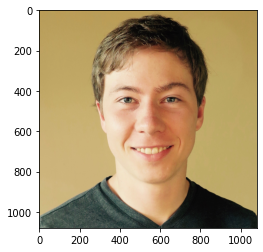

In [3]:
# 색깔 보정 처리해주기
# plt.imshow 이전에는 RGB로 바꿔주어야 함!
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

## Face Detection

- dlib의 face detector 이용해서 빠르게 object detection을 해보자!
    - HOG(Histogram of Oriented Gradient) feature를 사용
    - SVM(Support Vector Machine)의 sliding window로 얼굴을 찾음

추가) [알고리즘 상세 설명](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)

- 1) 먼저 사진에 있는 모든 얼굴을 찾는다.
- 2) 각 얼굴에 초점을 맞추고, 방향이 틀어지거나 조명에 따라 다르게 보여도 같은 사람임을 분별할 수 있어야 한다.
- 3) 눈이 얼마나 큰지, 얼굴형은 어떤지 등 다른 사람들과 구분되는 고유한 특징을 찾아낸다.
- 4) 그 고유한 특징을 다른 사람들과 비교해서 각자의 이름을 말할 수 있다.

### 얼굴 인식을 위한 기본 pipeline의 동작 방식

- 1) Find face in image
- 2) Analyze facial features
- 3) Compare against known faces
- 4) Make a prediction

### 추가) 이미지에서 gradient를 feature로 사용하는 이유?
- RGB값 자체보다는 인접한 픽셀들 사이의 색상 변화율이 그 오브젝트의 특징을 더 정확하게 반영할 때가 많기 때문이다.
- 즉 조명에 따라 픽셀값과 그 분포는 완전히 달라질 수 있지만, 밝기가 변하는 방향(그래디언트)만 고려한다면 주변 상황과 무관하게 동일한 표현(representation)을 얻을 수 있다!
- 다만 단일 픽셀의 그래디언트만 다루는 것보다는, 이미지의 전체적인 기본 패턴을 알기 위해 픽셀보다 높은 수준에서의 흐름/패턴을 보는 게 중요하다. 때문에 16x16 정사각형을 이용한다.

## 1) Face Detection
- HOG(HIstogram of Oriented Gradients) 사용
- 1-1) 이미지를 grayscale로 바꾸기
- 1-2) 각각의 모든 픽셀들을, 이를 둘러싼 주변 픽셀들과 비교해서 얼마나 어두운지 알아낸다. 이미지가 어두워지는 방향을 화살표로 나타낸다.
- 1-3) 이를 모든 픽셀에 대해 반복하면, 결국 모든 픽셀이 화살표가 된다. 이 화살표들을 gradients라고 한다.

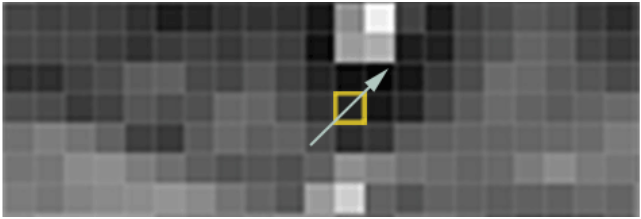

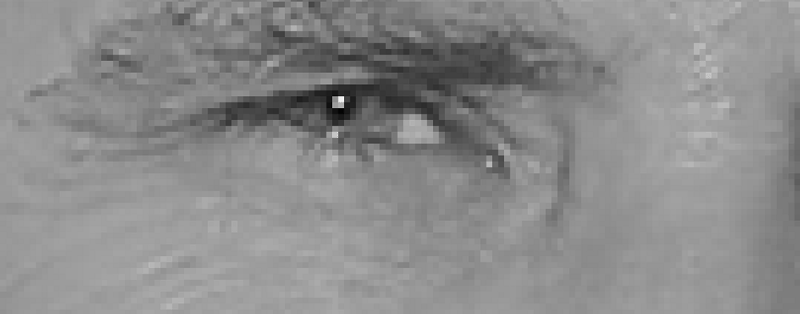

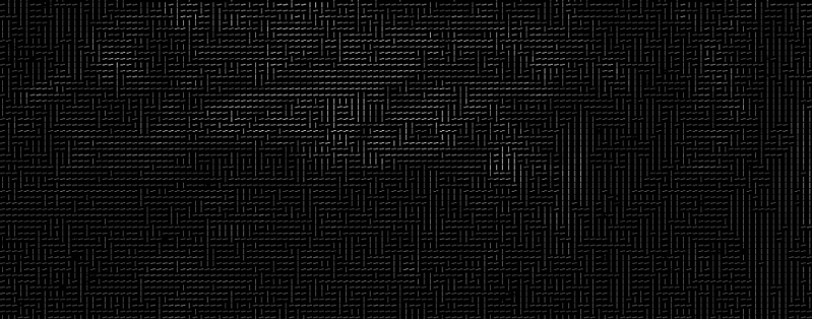

근데 이건 너무 자세하니까, 이미지를 각각 16x16 픽셀의 작은 정사각형으로 분해한다.

각 정사각형에서의 그래디언트를 보자.

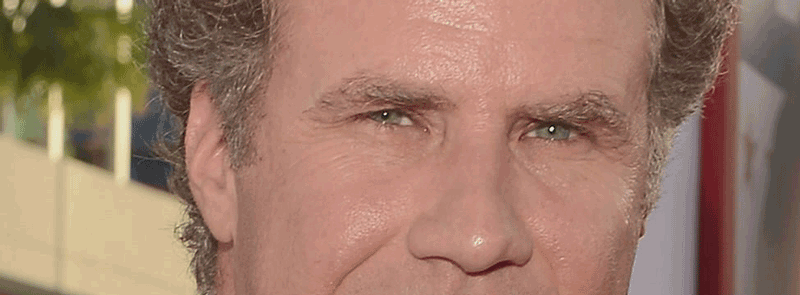

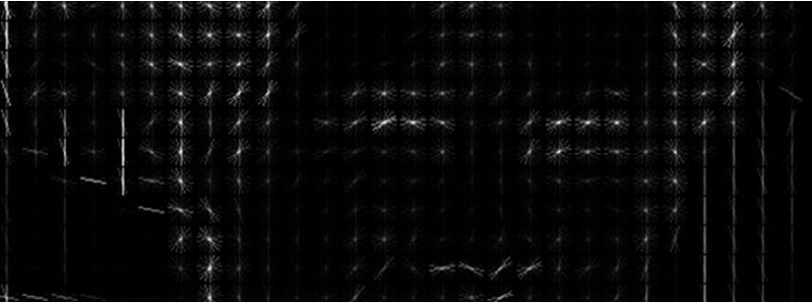

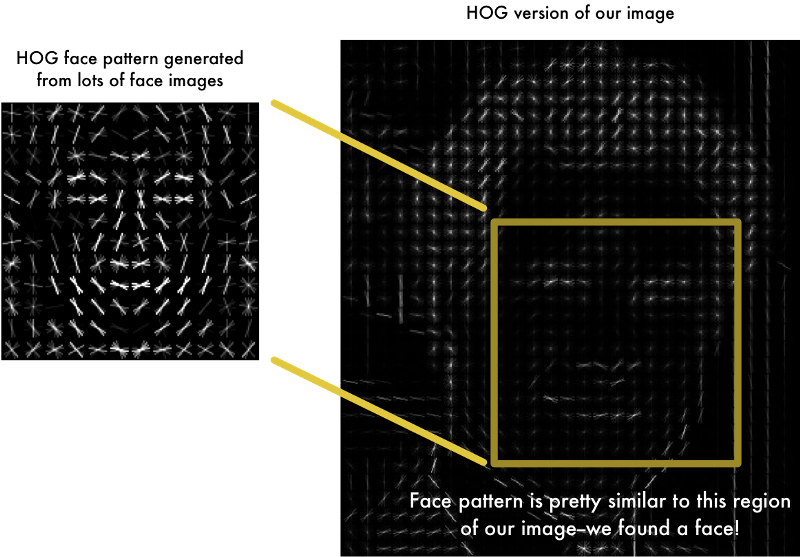

## 2) 얼굴의 위치 교정과 투영

- 문제: 얼굴이 다른 방향을 볼 때, 컴퓨터에게는 전혀 다르게 보임
- 해결 방법: 사진을 비틀어 눈과 입술이 항상 표준 위치에 오도록 하다.

#### face landmark estimation이라는 알고리즘 사용하기
- 기본 원리: 모든 얼굴에 존재하는 68개의 랜드마크를 찾아낸다.
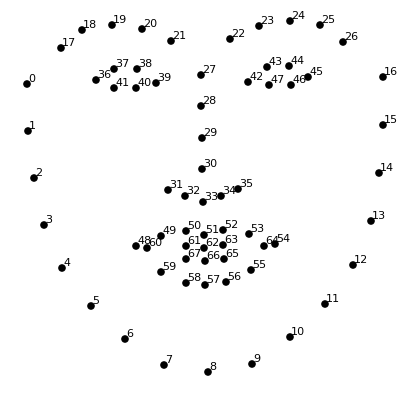

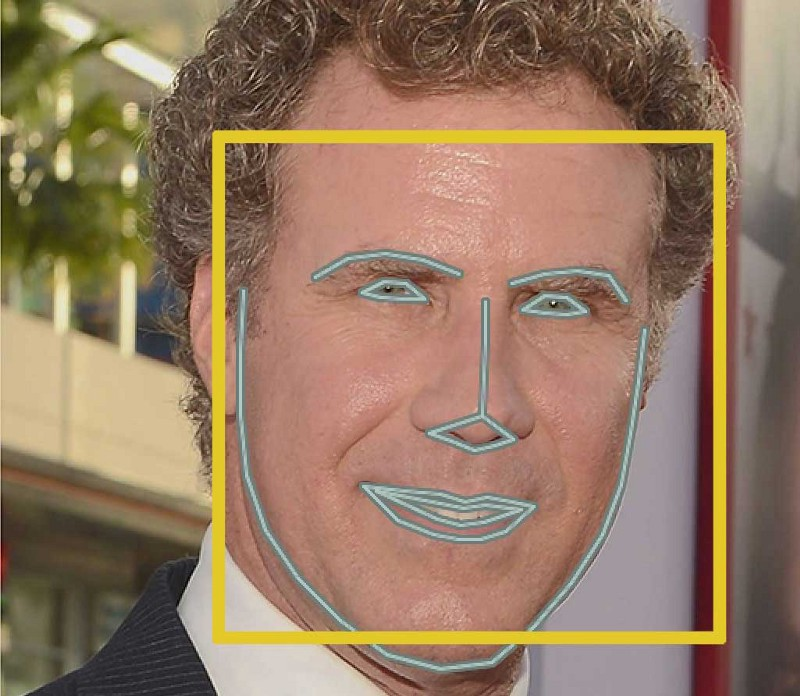

- 위 이미지에서 68개의 랜드마크를 표시했다.
- 눈과 입이 어디 있는지 알게 되었으므로, 이제 이들을 최대한 가운데로 오도록 이미지를 회전(rotate)하고, 크기를 조절(scale)하고, 비틀어보자(shear).
- 이미지 왜곡이 생길 수 있으므로 3d warps를 사용하지 않고, 평생선을 보존하는 수준의 기본적인 이미지 변환 방법만 사용한다.

추가)
- [얼굴 랜드마크 찾는 코드](https://gist.github.com/ageitgey/ae340db3e493530d5e1f9c15292e5c74)
- [랜드마크로 이미지를 변형하는 코드](https://gist.github.com/ageitgey/82d0ea0fdb56dc93cb9b716e7ceb364b)

## 3) 얼굴 인코딩

- 모든 얼굴과 비교하기에는 시간이 너무 오래 걸린다.
- 각 얼굴에서 몇 가지 기본 측정값을 추출하자. 딥러닝을 이용해서!
- CNN(Convolutional Neural Network)을 훈련시켜 각 얼굴에 대해 128개의 측정값을 생성하도록 한다.


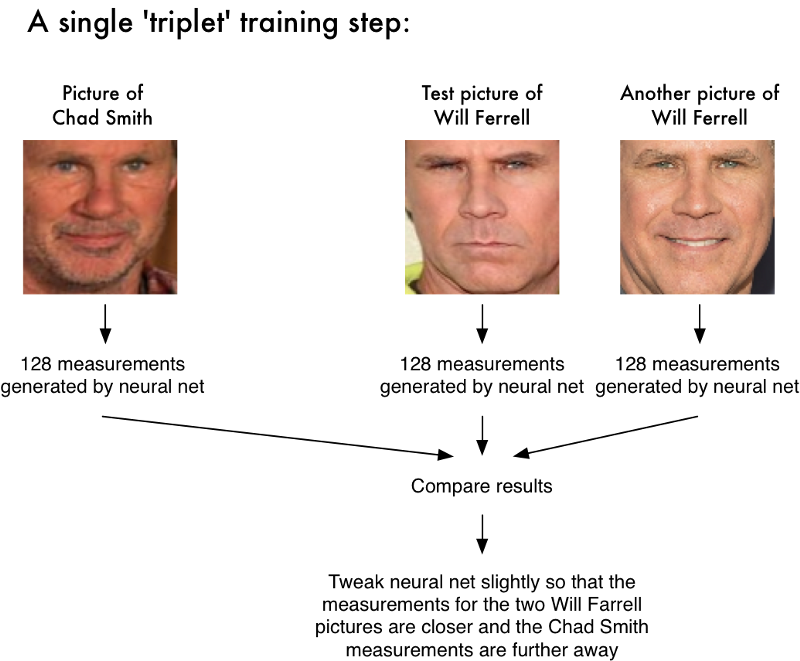

각 얼굴에 대한 128개의 측정값을 임베딩(embedding)이라고 부른다.

임베딩을 생성할 수 있도록 CNN을 train시키는 프로세스는 많은 양의 데이터와 컴퓨터 자원을 필요로 한다.
다행히도 [OpenFace](https://cmusatyalab.github.io/openface/)가 이미 이 작업을 진행한 다음, [우리가 바로 사용할 수 있는 모델](https://github.com/cmusatyalab/openface/tree/master/models/openface)을 공개했다.

우리는 이제 우리의 테스트 이미지에 대해 128개의 측정 값을 얻기만 하면 된다.

사실 이 128개의 숫자들이 정확히 얼굴의 어느 부분을 측정한 건지는 알 수 없다. 그러나 중요한 건, 동일한 사람의 다른 두 개의 사진에 대해 거의 같은 숫자를 생성한다는 사실이다!!

## 4) 인코딩에서 사람의 이름 찾기

- 이제 테스트 이미지에 가장 근접한 측정값을 가진 사람을 데이터베이스에서 찾기만 하면 된다.
- 이건 기본 머신러닝 분류기를 사용하면 된다. 우리는 SVM을 사용하자.

----

In [4]:
# dlib을 활용해 hog detector 선언하기
import dlib

detector_hog = dlib.get_frontal_face_detector()

# detector를 이용해 얼굴의 bounding box 추출하기
dlib_rects = detector_hog(img_rgb, 1)

### 이미지 피라미드?

[자세한 설명](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

detector_hob의 두번째 파라미터는 이미지 피라미드의 수이다.

이미지를 unsampling하는 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 한다.

이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.

rectangles[[(295, 295) (849, 850)]]


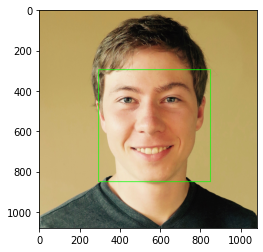

In [5]:
# 찾은 얼굴 영역 출력하기
print(dlib_rects)  # 얼굴 영역 좌표 출력

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### [cv2.rectangle(img, start, end, color, thickness)](https://opencv-python.readthedocs.io/en/latest/doc/03.drawShape/drawShape.html)
- cv2에서 도형 그리기는 동영상이나 이미지에서 Match가 되는 영역을 찾은 후에 사용자가 인식하기 쉽게 표시하는 목적으로 사용된다.
    - 관련 메서드로 line, circle, rectangle, putText가 있다.
- 사각형 그리기는 top-left corner와 bottom-right corner를 연결하는 사각형을 그린다.
- start: 시작 좌표 = (left, top)
- end: 종료 좌표 = (right, bottom)
- color: BGR 형태의 color(무슨 색으로 사각형을 그릴 건지)
- thickness: 선의 두께. 기본 값은 1
- lineType: 아래 중 선택
    - cv2.LINE_4
    - cv2.LINE_8 (default)
    - cv2.LINE_AA (곡선이 더 자연스러움)
- shift: 그리기 좌표 값의 축소 비율. 기본 값은 0
- 주의: grayscale 이미지/영상에는 컬러로 그리기가 불가능하다. 컬러로 변환한 후에 그리기 함수를 호출할 것!

## Face Landmark

- 이목구비 위치를 추론하는 것을 face landmark localization이라고 한다.
- 이미지 객체 내부의 점을 찾는 기술 = Object Keypoint Estimation
    - keypoint를 찾는 알고리즘에는 2가지가 있다.
    - 1) top-down: bounding box를 찾고 box 내부의 keypoint를 예측
    - 2) bottom-up: 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화해서 box 생성

이번에는 1번 방식으로 해보자.

### Dlib landmark localization
- 얼굴 bounding box에서 68개 이목구비 위치를 찾자
- 개수는 데이터셋과 논문마다 다르다.
    - [AFLW 데이터셋](https://www.tugraz.at/institute/icg/research/team-bischof/lrs/downloads/aflw/)은 21개를 사용
    - [ibug 300w 데이터셋](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)은 68개를 사용
- dlib은 ibug 300w 데이터셋으로 학습한 pretrained model을 제공한다.
    - [학습 알고리즘](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)은 regression tree의 앙상블 모델을 사용

In [6]:
model_path = os.getenv('HOME') + '/aiffel/aiffel_projects/data/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

### class dlib.shape_predictor
- __call__(self: dlib.shape_predictor, image: array, box: dlib.rectoangle) -> dlib.full_object_detection

### class dlib.full_object_detection
- __init__(self, rect: dlib.rectangle, parts: object) -> None
    - parts: list of dlib.point, or a dlib.points object
- parts() -> dlib.points
    - A vector of dlib points representing all of the parts.

In [7]:
# landmark_predictor는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection을 반환한다.
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    

print(len(list_landmarks[0]))

68


### cv2.circle(img, center, radian, color, thickness)
- center: 원의 중심 좌표(x, y)
- radian: 반지름
- thickness: -1이면 원 안쪽을 채움!!

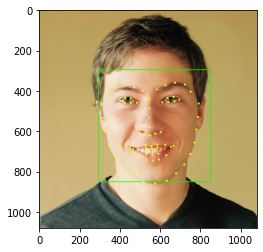

In [8]:
# 랜드마크를 영상에 출력하기
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)  # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### cv2.putText(img, text, org, font, fontSacle, color)
- org: 문자열이 표시될 위치. 문자열의 bottom-left corner 점
- font: font type. CV2.FONT_XXX
- fontSacle: Font Size

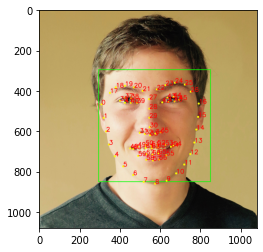

In [9]:
# 랜드마크를 영상에 출력하기       
copied = img_show_rgb.copy()

for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.putText(copied, str(idx), point, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)  # red

plt.imshow(copied)
plt.show()

## 스티커 적용하기
- 랜드마크를 기준으로 눈썹 위 얼굴 중앙에 스티커 씌우기
- 코의 중심을 기준으로 높이 x 이상에 그려도 되고,
- 눈썹 위에 n 픽셀 위에 그려도 된다.
- 중요한 건, 얼굴 위치, 카메라의 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산을 해야 한다는 것!
- 다음 두 가지를 계산해야 한다.
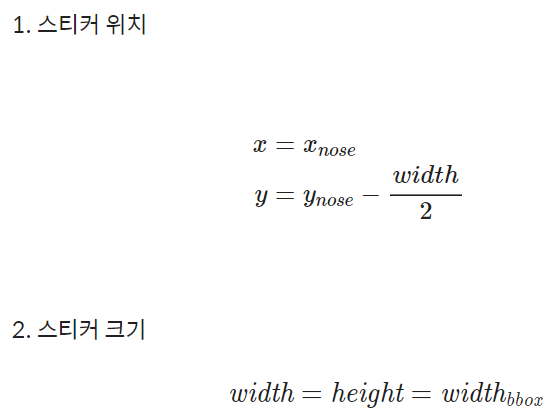

In [10]:
# 좌표 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])  # nose center index: 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print('(x,y): (%d, %d)'%(x, y))
    print('(w,h): (%d, %d)'%(w, h))

(548, 580)
(x,y): (548, 303)
(w,h): (555, 555)


In [11]:
# 준비해둔 스티커 이미지 읽어와서 적용해보자
# 위에서 계산한 크기로 resize
sticker_path = os.getenv('HOME') + '/aiffel/aiffel_projects/data/camera_sticker/images/king.png'

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

print(img_sticker.shape)

(555, 555, 3)


In [12]:
# 이제 스티커 이미지를 원본 이미지에 올려보자!
# 먼저 x, y 좌표 조정하기
refined_x = x - w //2   # left
refined_y = y - h       # top

print('(x,y): (%d, %d)'%(refined_x, refined_y))

(x,y): (271, -252)


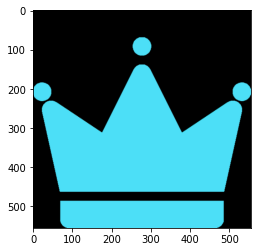

In [13]:
plt.imshow(img_sticker)
plt.show()

- 이미지 범위 밖 스티커 제거 필요!

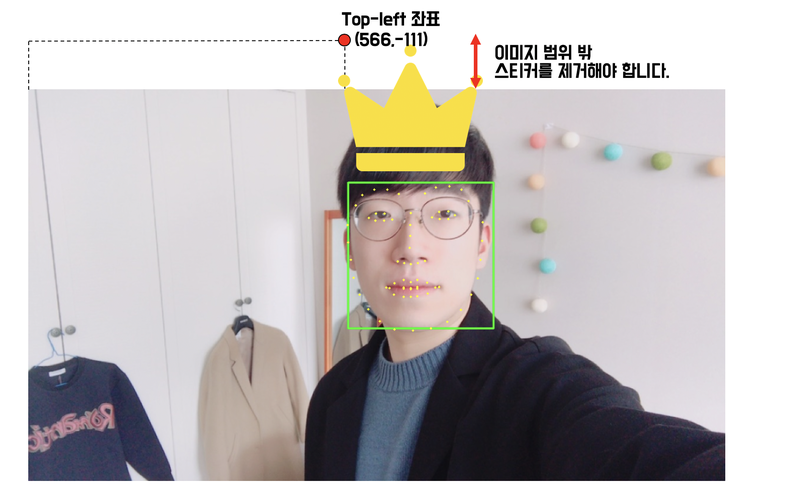

In [14]:
# 원본 이미지의 범위를 벗어난 스티커 부분 제거하기
img_sticker = img_sticker[-refined_y:]
print(img_sticker.shape)

(303, 555, 3)


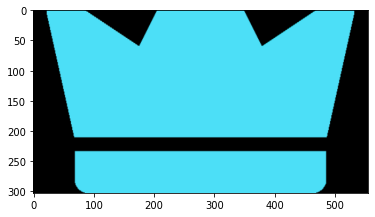

In [15]:
plt.imshow(img_sticker)
plt.show()

In [16]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (271,0)


In [17]:
img_sticker.shape

(303, 555, 3)

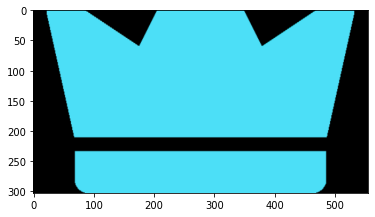

In [18]:
plt.imshow(img_sticker)
plt.show()

In [19]:
# 원본 이미지에 스티커 적용하기
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0, sticker_area, img_sticker).astype(np.uint8)

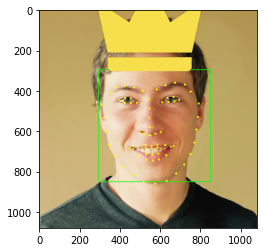

In [20]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

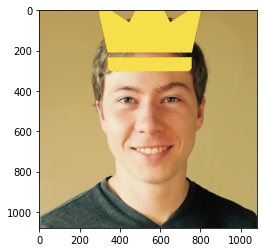

In [21]:
# bounding box와 landmark 제거해서 최종 결과만 출력하기
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()